In [1]:
import numpy as np
import math
from scipy import optimize
from IPython import display as dp
import pylab as pl

## Background

The values in the short rate lattice are of the form $r_{ks}=a_ke^{b_ks}$

k is the time (0,1..n)
s is the state (0,1...k)
$a_k$ is a measure of aggregate drift, asigned to match the implied term structure
$b_k$ is the volatility of the logarithim of the short rate from time k-1 to k

# Short-rate-lattice trees

-  Maturity T <br>
-  Time_step 
<br>
OBS: T/time_step must be an integer

The class short_rate_lattice assemble the short-rate lattice in the form of a dictionary whose keys are the periods and values are the discount rates. The lattice can be acessed trough the attribute .sr_lattice. 

The build method is called at __init__, thus the class it is ready to go. However, the rates and the sigma are randomly generated. We want a procedure in which those are input variables.

In [2]:
class short_rate_lattice():
    def __init__(self,T,time_step):
        self.time_step = time_step
        self.T=T
        self.n_of_periods = T/time_step
        self.time = np.arange(0,T,time_step)
        self.period = np.arange(int(self.n_of_periods))
        self.ir = np.random.rand(int(self.n_of_periods))
        self.sigma = np.random.rand(int(self.n_of_periods))
        self.sigma[0] = 0
        self.build_sr()
    def setup(self,ir,sigma):
        self.ir = ir
        self.sigma = sigma
        self.build_sr()
         
    def build_sr(self):
        self.sr_lattice = {}
        for i in self.period:            
            bin_ = self.ir[i]*np.exp(np.arange(i+1)*2*self.sigma[i]*np.sqrt(self.time_step))
            self.sr_lattice[i]=bin_

In [3]:
srl = short_rate_lattice(T=3,time_step=1)

In [4]:
ir = [0.0953,0.0923,0.0940]
sigma = [0,0.19,0.172]
srl.setup(ir,sigma)
srl.build_sr()

In [5]:
srl.sr_lattice

{0: array([0.0953]),
 1: array([0.0923    , 0.13496887]),
 2: array([0.094     , 0.13259439, 0.18703482])}

# Binomial Trees

The class tree will assemble a binomial tree with T periods whose face values at maturity are one. The FV can be alterred with the attribute FV. The method build acalculate the tree components and the price. Both can be accessed trough the attributes .tree and .p respectively.

A tree requires a short-rate-lattice object.

In [6]:
class Tree():
    def __init__(self,T,srl):
        self.srl = srl
        self.T = T
        self.n_of_periods = srl.n_of_periods
        self.period = np.arange(T)+1
        #self.build()
        
    def build(self):   
        self.tree = {}
        self.tree[self.T]=np.ones(self.T+1)
        for i in np.flip(self.period,axis=0):
                       
            self.tree[i-1] = 0.5*(self.tree[i][:-1] + np.roll(self.tree[i],shift=-1)[:-1])*np.exp(-self.srl.sr_lattice[i-1])
            
        self.p = self.tree[0][0]
        self.get_vol()
        
        return self.p,self.vol
        
    def get_vol(self):
        
        if self.T !=1:
            rates = np.log(self.tree[1])/(self.T-1)
            self.vol = 0.5*np.log(rates[1]/rates[0])/np.sqrt(self.srl.time_step)
        else:
            self.vol = 0
        
        pass

In [9]:
Tr = Tree(3,srl)
Tr.build()
print('price: {}'.format(Tr.p))

price: 0.7087714297730028


In [10]:
Tr.tree

{0: array([0.70877143]),
 1: array([0.81431255, 0.74496872]),
 2: array([0.91028276, 0.87582026, 0.82941486]),
 3: array([1., 1., 1., 1.])}

In [9]:
Tr.vol

0.7937308040360631

# Building a model

The BDT class builds a short rate tree and all required tress for the bonds wih different maturities. It is a subclass of the short_rate_lattice and Tree classes. The method loss calculates the loss given a interest rate(ir) and volatility(vol) series.

Ex. 3 year maturity, with a time step of one year.
<br> Market_Data = {'Price': [0.9091,0.8116,0.7118],'Vol':[0,.19,.18]}


Here I am experimenting with multiprocessing in python:
http://sebastianraschka.com/Articles/2014_multiprocessing.html
http://kmdouglass.github.io/posts/learning-pythons-multiprocessing-module.html

In [11]:
T = 3
time_step=1
mkt_data = {'Price': [0.9091,0.8116,0.7118],'Vol':[0,.19,.18]}

In [22]:
import multiprocessing as mp

class BDT(short_rate_lattice,Tree):
    def __init__(self,T,time_step,mkt_data):
        self.loss_bin = []
        self.T=T
        self.time_step = time_step
        self.n_of_periods = T/time_step
        self.srl = short_rate_lattice(T,time_step)
        self.build_Trees()
        self.mkt_data = mkt_data
        self.random_seed()
    
    def random_seed(self):
        self.ir = -1*np.divide(np.log(self.mkt_data['Price']),np.arange(self.time_step,self.T+self.time_step,self.time_step))
        self.vols = np.array(self.mkt_data['Vol'])
        self.vols[0] = 0
        self.x0 = np.vstack([self.ir,self.vols])
        
    def build_Trees(self):
        trees_T = np.arange(int(self.n_of_periods))+1
        self.trees = {}
        self.tree_prices = []
        self.tree_vols = []        
        
        for i in trees_T:
            self.trees[i]= Tree(i,self.srl)
            
        pool = mp.Pool(processes=6)
        results = [pool.apply(self.trees[x].build) for x in trees_T]
        self.tree_prices,self.tree_vols = zip(*results)
        pool.close()

            
    def loss(self,x):
        ir = x[:len(self.ir)]
        vols = np.append(0,x[len(self.ir):])
        
        self.srl.setup(ir,vols)
        self.build_Trees()
                
        ps = (np.array(self.tree_prices) - self.mkt_data['Price'])
        vs = (np.array(self.tree_vols) - self.mkt_data['Vol'])
        loss = np.append(ps,vs)
        
        loss = 1000*loss.dot(loss)

        self.plot_ps(self.tree_prices,self.tree_vols)
            
        return loss
    
    def plot_loss(self,loss):
        pl.title('Total loss')
        pl.plot(loss)
        dp.display(pl.gcf())
        dp.clear_output(wait=True)
    
    def plot_ps(self,p,v):
        N = np.arange(len(p))
        pindex = np.array(p)/np.array(self.mkt_data['Price'])
        vindex = np.array(v)/self.mkt_data['Vol']
        pl.title('Relatives price and vol')
        pl.plot(N,pindex,label='price')
        pl.plot(N,vindex,label='vol')

        dp.display(pl.gcf())
        dp.clear_output(wait=True)
        pl.gcf().clear() 
        
    
    def solve(self,method ='BFGS',options={},bounds=[]):
        ir = self.ir 
        vols = self.vols 
        x0 = np.append(self.ir,self.vols[1:])
        if method=='diff':
            self.opt_results = differential_evolution(self.loss,bounds=bounds)
        else:
            self.opt_results = optimize.minimize(self.loss,x0=x0,tol=10,
                                             method=method,bounds=bounds,options=options)
        self.ir_op = self.opt_results.x[:len(self.ir)]
        self.vols_op = self.opt_results.x[:len(self.ir)]
        print(self.opt_results)

In [13]:
method = 'BFGS'
options={'maxiter':50,'disp':True,'xtol':1e-10,'eps':1e-10,
         'maxls':80,'gtol':1e-8,'ftol':1e-2}

bdt = BDT(3,1,mkt_data)
bdt.solve(method=method,options=options)
print('Concluded: {}'.format(method))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 133
         Gradient evaluations: 19
      fun: 7.847453896610579e-18
 hess_inv: array([[ 6.02924972e-04, -4.91314854e-04, -1.13426979e-05,
         1.21556705e-06,  4.33276446e-05],
       [-4.91314854e-04,  9.10917379e-04, -4.11376656e-04,
        -5.49522642e-05, -7.80546404e-05],
       [-1.13426979e-05, -4.11376656e-04,  8.85453525e-04,
         9.01370573e-05, -3.20976821e-04],
       [ 1.21556705e-06, -5.49522642e-05,  9.01370573e-05,
         4.99582110e-04, -4.28702080e-04],
       [ 4.33276446e-05, -7.80546404e-05, -3.20976821e-04,
        -4.28702080e-04,  2.13425316e-03]])
      jac: array([-1.71586945e-11, -3.55302694e-12, -5.54266765e-12,  7.02214934e-12,
       -6.94754146e-12])
  message: 'Optimization terminated successfully.'
     nfev: 133
      nit: 12
     njev: 19
   status: 0
  success: True
        x: array([0.09530018, 0.092333

In [15]:
method = 'Nelder-Mead'
options={'maxiter':50,'disp':True,'xtol':1e-10,'eps':1e-10,
         'maxls':80,'gtol':1e-8,'ftol':1e-3}

bdt = BDT(3,1,mkt_data)
bdt.solve(method=method,options=options)
print('Concluded: {}'.format(method))


Optimization terminated successfully.
         Current function value: 1.347914
         Iterations: 1
         Function evaluations: 6
 final_simplex: (array([[0.09530018, 0.10437384, 0.11331944, 0.19      , 0.18      ],
       [0.09530018, 0.10437384, 0.11331944, 0.19      , 0.189     ],
       [0.09530018, 0.10437384, 0.11331944, 0.1995    , 0.18      ],
       [0.10006519, 0.10437384, 0.11331944, 0.19      , 0.18      ],
       [0.09530018, 0.10437384, 0.11898541, 0.19      , 0.18      ],
       [0.09530018, 0.10959253, 0.11331944, 0.19      , 0.18      ]]), array([1.34791447, 1.579391  , 1.5834294 , 1.70395078, 1.76220034,
       1.81083962]))
           fun: 1.3479144729211887
       message: 'Optimization terminated successfully.'
          nfev: 6
           nit: 1
        status: 0
       success: True
             x: array([0.09530018, 0.10437384, 0.11331944, 0.19      , 0.18      ])
Concluded: Nelder-Mead


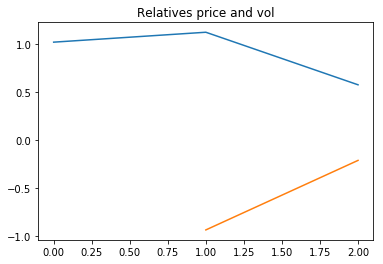

In [ ]:
from scipy.optimize import differential_evolution
method = 'diff'
options={'maxiter':50,'disp':True,'xtol':1e-10,'eps':1e-10,
         'maxls':80,'gtol':1e-8,'ftol':1e-2,'polish':True}
bounds = []
for i in np.arange(6):
    bounds.append((-1,1))

bdt = BDT(3,1,mkt_data)
bdt.solve(method=method,options=options,bounds=bounds)
print('Concluded: {}'.format(method))


# Ratio between model and market prices

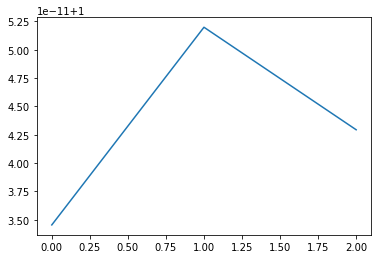

In [13]:
error = []
calculated_ps = []
for i in bdt.trees.keys():
    error.append(bdt.trees[i].p/mkt_data['Price'][i-1])
    calculated_ps.append(bdt.trees[i].p)
pl.plot(error)

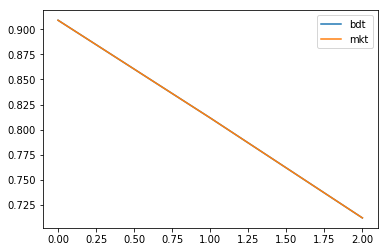

In [14]:
pl.plot(calculated_ps,label='bdt');
pl.plot(mkt_data['Price'],label='mkt')
pl.legend()

In [16]:
method = 'L-BFGS-B'
options={'maxiter':50,'disp':True,'xtol':1e-10,'eps':1e-10,
         'maxls':80,'gtol':1e-8,'ftol':1e-2}
bounds = []
for i in np.arange(6):
    bounds.append((-1,1))

bdt = BDT(3,1,mkt_data)
bdt.solve(method=method,bounds=bounds,options=options)

      fun: 0.0002633099170424857
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01059641,  0.08034279,  0.10264763,  0.        ,  0.20838242,
       -0.42449511])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 56
      nit: 5
   status: 0
  success: True
        x: array([0.09524487, 0.09238569, 0.09126617, 0.        , 0.19029196,
       0.17070096])
